In [ ]:
# Now let's try to predict the full 2D adjacency matrix

In [1]:
%load_ext tensorboard

In [2]:
%tensorboard --logdir=logs --host localhost --port=6007

In [5]:
import pandas as pd
import numpy as np
# Load the Parquet file
df = pd.read_parquet("IR_v09_df_all_features.parquet")

# Reconstruct the original 2D matrices
df['Merged Adjacency Matrix'] = df.apply(
    lambda row: np.array(row['Merged Adjacency Matrix']).reshape(row['Matrix_Shape']),
    axis=1
)

Epoch [5/1000], Train Loss: 1.4129, Val Loss: 1.3926, LR: 0.000010
Epoch [10/1000], Train Loss: 1.3624, Val Loss: 1.3764, LR: 0.000010
Epoch [15/1000], Train Loss: 1.3495, Val Loss: 1.3661, LR: 0.000010
Epoch [20/1000], Train Loss: 1.3383, Val Loss: 1.3552, LR: 0.000010
Epoch [25/1000], Train Loss: 1.3294, Val Loss: 1.3459, LR: 0.000010
Epoch [30/1000], Train Loss: 1.3228, Val Loss: 1.3390, LR: 0.000010
Epoch [35/1000], Train Loss: 1.3145, Val Loss: 1.3315, LR: 0.000010
Epoch [40/1000], Train Loss: 1.3097, Val Loss: 1.3260, LR: 0.000010
Epoch [45/1000], Train Loss: 1.3053, Val Loss: 1.3193, LR: 0.000010
Epoch [50/1000], Train Loss: 1.2991, Val Loss: 1.3162, LR: 0.000010
Epoch [55/1000], Train Loss: 1.2935, Val Loss: 1.3095, LR: 0.000010
Epoch [60/1000], Train Loss: 1.2859, Val Loss: 1.3015, LR: 0.000010
Epoch [65/1000], Train Loss: 1.2759, Val Loss: 1.2966, LR: 0.000010
Epoch [70/1000], Train Loss: 1.2637, Val Loss: 1.2866, LR: 0.000010
Epoch [75/1000], Train Loss: 1.2534, Val Loss: 1.

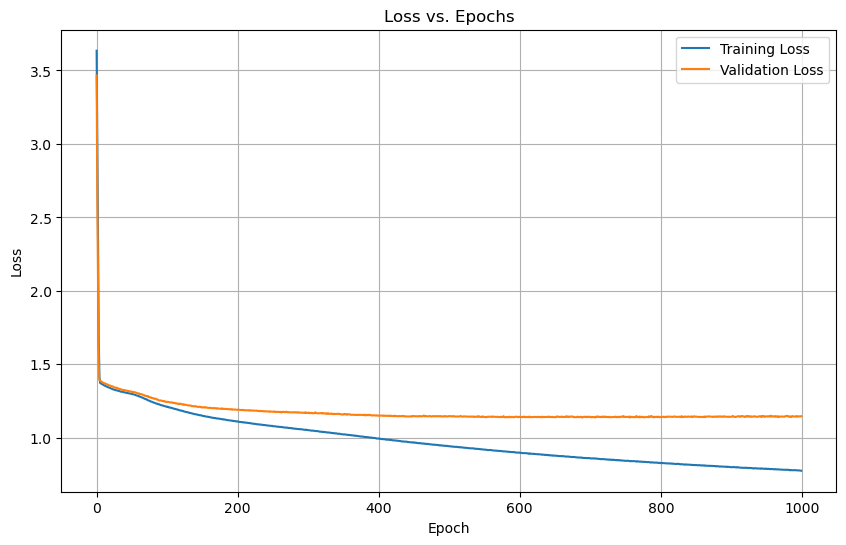

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import datetime

##############################################
# Prepare Data: Extract Merged Adjacency Matrix
##############################################

# Convert (80x160) matrices into tensors without flattening
y = np.stack(df['Merged Adjacency Matrix'].values)  # Shape: (num_samples, 80, 160)

# Standardize the input data from the 'y' column
X = np.log(np.vstack(df['y'].values) + 1)  # Convert to 2D array and take log
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 80, 160)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 80, 160)

# Create DataLoader for minibatch training
batch_size = 8
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

##############################################
# Neural Network for Predicting Binary Matrix Values
##############################################

class MatrixPredictorNN(nn.Module):
    def __init__(self, D_in, H1, H2, H3, rows, cols):
        super(MatrixPredictorNN, self).__init__()
        self.hidden1 = nn.Linear(D_in, H1)
        self.hidden2 = nn.Linear(H1, H2)
        self.hidden3 = nn.Linear(H2, H3)
        self.output = nn.Linear(H3, rows * cols)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        out = torch.sigmoid(self.output(x))
        return out.view(-1, 80, 160)  # Reshape to (80, 160)

# Initialize the network
D_in = X_train_tensor.shape[1]
H1, H2, H3 = 256, 128, 64
rows, cols = 80, 160

net = MatrixPredictorNN(D_in, H1, H2, H3, rows, cols)

##############################################
# Set Up Optimization and Loss Function
##############################################
learning_rate=0.00001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2, eta_min=1e-5)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# Initialize TensorBoard writer
logdir = f"{datetime.now().strftime('%Y-%m-%d')}"
writer = SummaryWriter(log_dir="./logs/adjacency_mat/"+logdir+"_v2")
writer.add_text('Hyperparameters', f'Initial LR: {learning_rate}\nOptimizer: Adam\nScheduler: CosineAnnealingWarmRestarts\nEpochs: 2000')

##############################################
# Training Loop with MiniBatch Training and Image Logging
##############################################

num_epochs = 1000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_train_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = net(X_batch)

        # Binary Cross-Entropy loss
        bce_loss = criterion(outputs, y_batch)

        # Calculate confusion matrix-based metrics for training
        y_pred_binary = (outputs >= 0.3).float()
        acc = (y_pred_binary == y_batch).float().mean().item()
        prec = precision_score(
            y_batch.view(-1).numpy(),
            y_pred_binary.view(-1).numpy(),
            zero_division=0,
        )
        rec = recall_score(
            y_batch.view(-1).numpy(),
            y_pred_binary.view(-1).numpy(),
            zero_division=0,
        )
        f1 = f1_score(
            y_batch.view(-1).numpy(),
            y_pred_binary.view(-1).numpy(),
            zero_division=0,
        )

        # Metric loss
        metric_loss = (1 - acc) + (1 - prec) + (1 - rec) + (1 - f1)

        # Combine BCE loss and metric loss
        total_loss = bce_loss + metric_loss
        epoch_train_loss += total_loss.item()

        # Backpropagation and optimization
        total_loss.backward()
        optimizer.step()

    # Record average training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation loss and metrics
    net.eval()
    with torch.no_grad():
        val_outputs = net(X_test_tensor)
        val_bce_loss = criterion(val_outputs, y_test_tensor)

        val_pred_binary = (val_outputs >= 0.3).float()
        val_acc = (val_pred_binary == y_test_tensor).float().mean().item()
        val_prec = precision_score(
            y_test_tensor.view(-1).numpy(),
            val_pred_binary.view(-1).numpy(),
            zero_division=0,
        )
        val_rec = recall_score(
            y_test_tensor.view(-1).numpy(),
            val_pred_binary.view(-1).numpy(),
            zero_division=0,
        )
        val_f1 = f1_score(
            y_test_tensor.view(-1).numpy(),
            val_pred_binary.view(-1).numpy(),
            zero_division=0,
        )

        val_metric_loss = (1 - val_acc) + (1 - val_prec) + (1 - val_rec) + (1 - val_f1)
        val_total_loss = val_bce_loss + val_metric_loss
        val_losses.append(val_total_loss.item())

    # Log losses to TensorBoard
    writer.add_scalar("Loss/Train", train_losses[-1], epoch + 1)
    writer.add_scalar("Loss/Validation", val_losses[-1], epoch + 1)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, epoch)
    
    # Log example images every 10 epochs
    if (epoch + 1) % 5 == 0:
        save_path = f"./adjmat_from_IRcheckpoints/model_epoch_{epoch + 1}.pt"
        torch.save(net.state_dict(), save_path)
        for i in range(3):  # Log 3 examples
            actual_image = y_test_tensor[i].numpy()
            predicted_image = val_outputs[i].numpy()

            writer.add_image(f"Actual/Example_{i+1}", actual_image, epoch + 1, dataformats="HW")
            writer.add_image(f"Predicted/Example_{i+1}", predicted_image, epoch + 1, dataformats="HW")

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {train_losses[-1]:.4f}, "
            f"Val Loss: {val_losses[-1]:.4f}, "
            f"LR: {current_lr:.6f}"
        )

##############################################
# Plot Training and Validation Losses
##############################################

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()

# Close TensorBoard writer
writer.close()


Epoch [5/2000], Train Loss: 2.4826, Val Loss: 2.3261, LR: 0.000005
Epoch [10/2000], Train Loss: 1.3941, Val Loss: 1.4064, LR: 0.000005
Epoch [15/2000], Train Loss: 1.3577, Val Loss: 1.3767, LR: 0.000005
Epoch [20/2000], Train Loss: 1.3565, Val Loss: 1.3761, LR: 0.000005
Epoch [25/2000], Train Loss: 1.3559, Val Loss: 1.3778, LR: 0.000005
Epoch [30/2000], Train Loss: 1.3548, Val Loss: 1.3768, LR: 0.000005
Epoch [35/2000], Train Loss: 1.3547, Val Loss: 1.3773, LR: 0.000005
Epoch [40/2000], Train Loss: 1.3530, Val Loss: 1.3766, LR: 0.000005
Epoch [45/2000], Train Loss: 1.3519, Val Loss: 1.3717, LR: 0.000005
Epoch [50/2000], Train Loss: 1.3479, Val Loss: 1.3720, LR: 0.000005
Epoch [55/2000], Train Loss: 1.3459, Val Loss: 1.3706, LR: 0.000005
Epoch [60/2000], Train Loss: 1.3446, Val Loss: 1.3664, LR: 0.000005
Epoch [65/2000], Train Loss: 1.3421, Val Loss: 1.3649, LR: 0.000005
Epoch [70/2000], Train Loss: 1.3395, Val Loss: 1.3602, LR: 0.000005
Epoch [75/2000], Train Loss: 1.3350, Val Loss: 1.

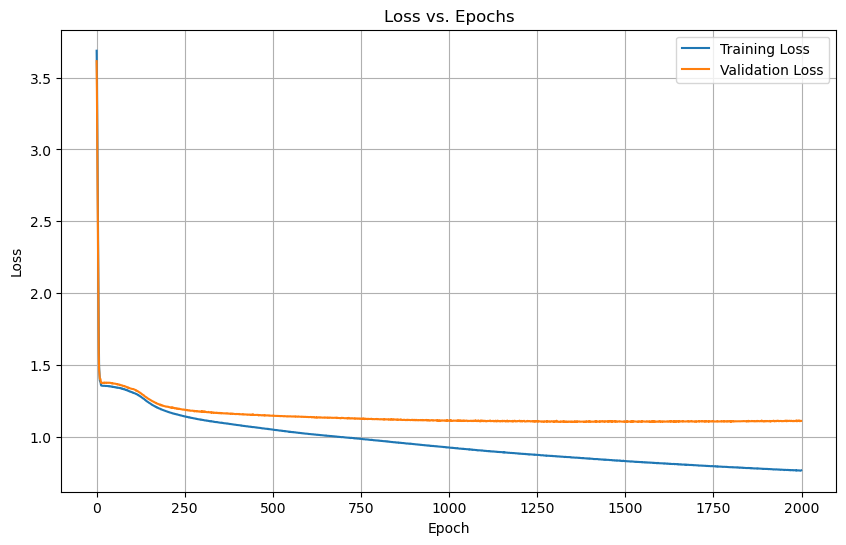

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import datetime

##############################################
# Prepare Data: Extract Merged Adjacency Matrix
##############################################

# Convert (80x160) matrices into tensors without flattening
y = np.stack(df['Merged Adjacency Matrix'].values)  # Shape: (num_samples, 80, 160)

# Standardize the input data from the 'y' column
X = np.log(np.vstack(df['y'].values) + 1)  # Convert to 2D array and take log
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 80, 160)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 80, 160)

# Create DataLoader for minibatch training
batch_size = 8
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

##############################################
# Neural Network for Predicting Binary Matrix Values
##############################################

class MatrixPredictorNN(nn.Module):
    def __init__(self, D_in, H1, H2, H3, rows, cols):
        super(MatrixPredictorNN, self).__init__()
        self.hidden1 = nn.Linear(D_in, H1)
        self.hidden2 = nn.Linear(H1, H2)
        self.hidden3 = nn.Linear(H2, H3)
        self.output = nn.Linear(H3, rows * cols)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        out = torch.sigmoid(self.output(x))
        return out.view(-1, 80, 160)  # Reshape to (80, 160)

# Initialize the network
D_in = X_train_tensor.shape[1]
H1, H2, H3 = 256, 128, 64
rows, cols = 80, 160

net = MatrixPredictorNN(D_in, H1, H2, H3, rows, cols)

##############################################
# Set Up Optimization and Loss Function
##############################################
learning_rate=0.000005
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2, eta_min=1e-5)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# Initialize TensorBoard writer
logdir = f"{datetime.now().strftime('%Y-%m-%d')}"
writer = SummaryWriter(log_dir="./logs/adjacency_mat/"+logdir)
writer.add_text('Hyperparameters', f'Initial LR: {learning_rate}\nOptimizer: Adam\nScheduler: CosineAnnealingWarmRestarts\nEpochs: 2000')

##############################################
# Training Loop with MiniBatch Training and Image Logging
##############################################

num_epochs = 2000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_train_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = net(X_batch)

        # Binary Cross-Entropy loss
        bce_loss = criterion(outputs, y_batch)

        # Calculate confusion matrix-based metrics for training
        y_pred_binary = (outputs >= 0.5).float()
        acc = (y_pred_binary == y_batch).float().mean().item()
        prec = precision_score(
            y_batch.view(-1).numpy(),
            y_pred_binary.view(-1).numpy(),
            zero_division=0,
        )
        rec = recall_score(
            y_batch.view(-1).numpy(),
            y_pred_binary.view(-1).numpy(),
            zero_division=0,
        )
        f1 = f1_score(
            y_batch.view(-1).numpy(),
            y_pred_binary.view(-1).numpy(),
            zero_division=0,
        )

        # Metric loss
        metric_loss = (1 - acc) + (1 - prec) + (1 - rec) + (1 - f1)

        # Combine BCE loss and metric loss
        total_loss = bce_loss + metric_loss
        epoch_train_loss += total_loss.item()

        # Backpropagation and optimization
        total_loss.backward()
        optimizer.step()

    # Record average training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation loss and metrics
    net.eval()
    with torch.no_grad():
        val_outputs = net(X_test_tensor)
        val_bce_loss = criterion(val_outputs, y_test_tensor)

        val_pred_binary = (val_outputs >= 0.5).float()
        val_acc = (val_pred_binary == y_test_tensor).float().mean().item()
        val_prec = precision_score(
            y_test_tensor.view(-1).numpy(),
            val_pred_binary.view(-1).numpy(),
            zero_division=0,
        )
        val_rec = recall_score(
            y_test_tensor.view(-1).numpy(),
            val_pred_binary.view(-1).numpy(),
            zero_division=0,
        )
        val_f1 = f1_score(
            y_test_tensor.view(-1).numpy(),
            val_pred_binary.view(-1).numpy(),
            zero_division=0,
        )

        val_metric_loss = (1 - val_acc) + (1 - val_prec) + (1 - val_rec) + (1 - val_f1)
        val_total_loss = val_bce_loss + val_metric_loss
        val_losses.append(val_total_loss.item())

    # Log losses to TensorBoard
    writer.add_scalar("Loss/Train", train_losses[-1], epoch + 1)
    writer.add_scalar("Loss/Validation", val_losses[-1], epoch + 1)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, epoch)
    
    # Log example images every 10 epochs
    if (epoch + 1) % 5 == 0:
        save_path = "./logs/adjacency_mat/"+logdir+f"/model_epoch_{epoch + 1}.pt"
        torch.save(net.state_dict(), save_path)
        for i in range(3):  # Log 3 examples
            actual_image = y_test_tensor[i].numpy()
            predicted_image = val_outputs[i].numpy()

            writer.add_image(f"Actual/Example_{i+1}", actual_image, epoch + 1, dataformats="HW")
            writer.add_image(f"Predicted/Example_{i+1}", predicted_image, epoch + 1, dataformats="HW")

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {train_losses[-1]:.4f}, "
            f"Val Loss: {val_losses[-1]:.4f}, "
            f"LR: {current_lr:.6f}"
        )

##############################################
# Plot Training and Validation Losses
##############################################

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()

# Close TensorBoard writer
writer.close()


In [ ]:
#Explore how the size of the training set influences the quality of the prediction

In [ ]:
#Reload model at specified epoch:

In [95]:
class MatrixPredictorNN(nn.Module):
    def __init__(self, D_in, H1, H2, H3, rows, cols):
        super(MatrixPredictorNN, self).__init__()
        self.hidden1 = nn.Linear(D_in, H1)
        self.hidden2 = nn.Linear(H1, H2)
        self.hidden3 = nn.Linear(H2, H3)
        self.output = nn.Linear(H3, rows * cols)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        out = torch.sigmoid(self.output(x))
        return out.view(-1, rows, cols)

In [96]:
# Reconstruct the model
D_in = X_train_tensor.shape[1]  # same input size as during training
H1, H2, H3 = 256, 128, 64
rows, cols = 80, 160
model = MatrixPredictorNN(D_in, H1, H2, H3, rows, cols)

# Specify the path to a model saved at a given epoch (e.g., epoch 100)
epoch_to_load = 2000
checkpoint_path = f"./logs/adjacency_mat/{logdir}/model_epoch_{epoch_to_load}.pt"

# Load weights
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.eval()  # Set to eval mode


MatrixPredictorNN(
  (hidden1): Linear(in_features=500, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=12800, bias=True)
)

In [97]:
#Reload data with train/test splits:
import pandas as pd
import numpy as np
# Load the Parquet file
df = pd.read_parquet("IR_v09_df_all_features.parquet")

# Reconstruct the original 2D matrices
df['Merged Adjacency Matrix'] = df.apply(
    lambda row: np.array(row['Merged Adjacency Matrix']).reshape(row['Matrix_Shape']),
    axis=1
)

In [98]:
##############################################
# Prepare Data: Extract Merged Adjacency Matrix
##############################################

# Convert (80x160) matrices into tensors without flattening
y = np.stack(df['Merged Adjacency Matrix'].values)  # Shape: (num_samples, 80, 160)

# Standardize the input data from the 'y' column
X = np.log(np.vstack(df['y'].values) + 1)  # Convert to 2D array and take log
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 80, 160)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 80, 160)

# Create DataLoader for minibatch training
batch_size = 8
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

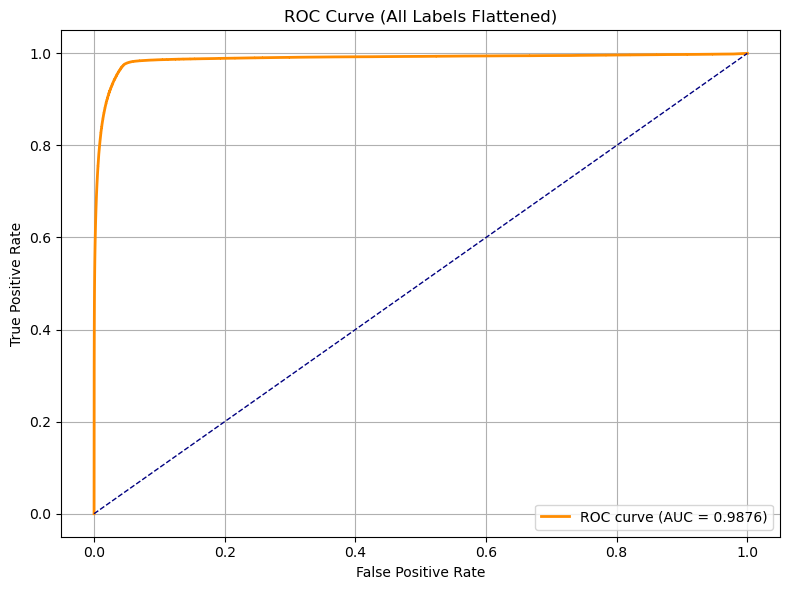

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

##############################################
# Evaluate the Model and Collect Predictions
##############################################

model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Flatten predictions and true labels for ROC analysis
y_score = y_pred_tensor.view(-1).numpy()
y_true = y_test_tensor.view(-1).numpy()

##############################################
# Compute ROC Curve
##############################################

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

##############################################
# Plot ROC Curve
##############################################

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (All Labels Flattened)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


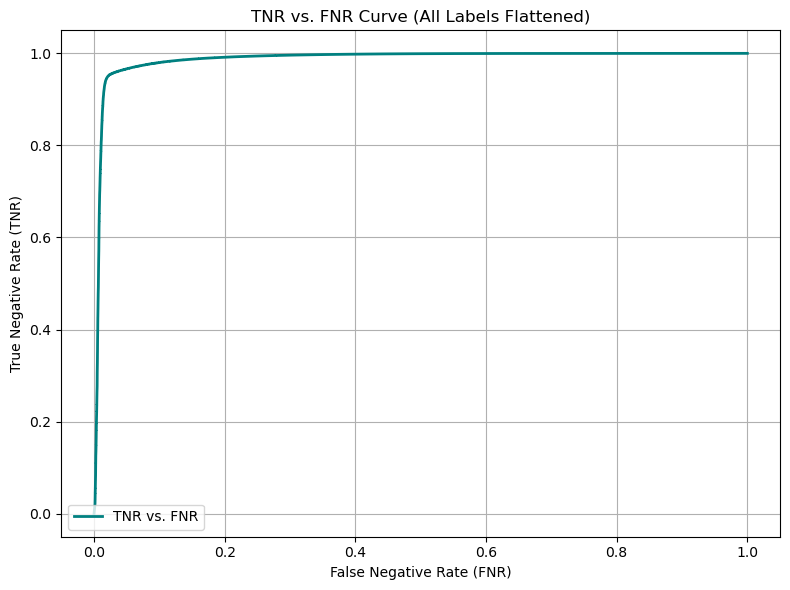

In [100]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

##############################################
# Evaluate the Model and Collect Predictions
##############################################

model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Flatten predictions and true labels for ROC-style analysis
y_score = y_pred_tensor.view(-1).numpy()
y_true = y_test_tensor.view(-1).numpy()

##############################################
# Compute FNR and TNR from ROC Curve
##############################################

# fpr = False Positive Rate, tpr = True Positive Rate
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Compute derived rates
fnr = 1 - tpr  # False Negative Rate = 1 - TPR
tnr = 1 - fpr  # True Negative Rate = 1 - FPR

##############################################
# Plot TNR vs. FNR
##############################################

plt.figure(figsize=(8, 6))
plt.plot(fnr, tnr, color='teal', lw=2, label='TNR vs. FNR')
plt.xlabel('False Negative Rate (FNR)')
plt.ylabel('True Negative Rate (TNR)')
plt.title('TNR vs. FNR Curve (All Labels Flattened)')
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()



Metrics for Matrix Prediction:
  Accuracy:  0.9956
  Precision: 0.6137
  Recall:    0.6297
  F1 Score:  0.6216


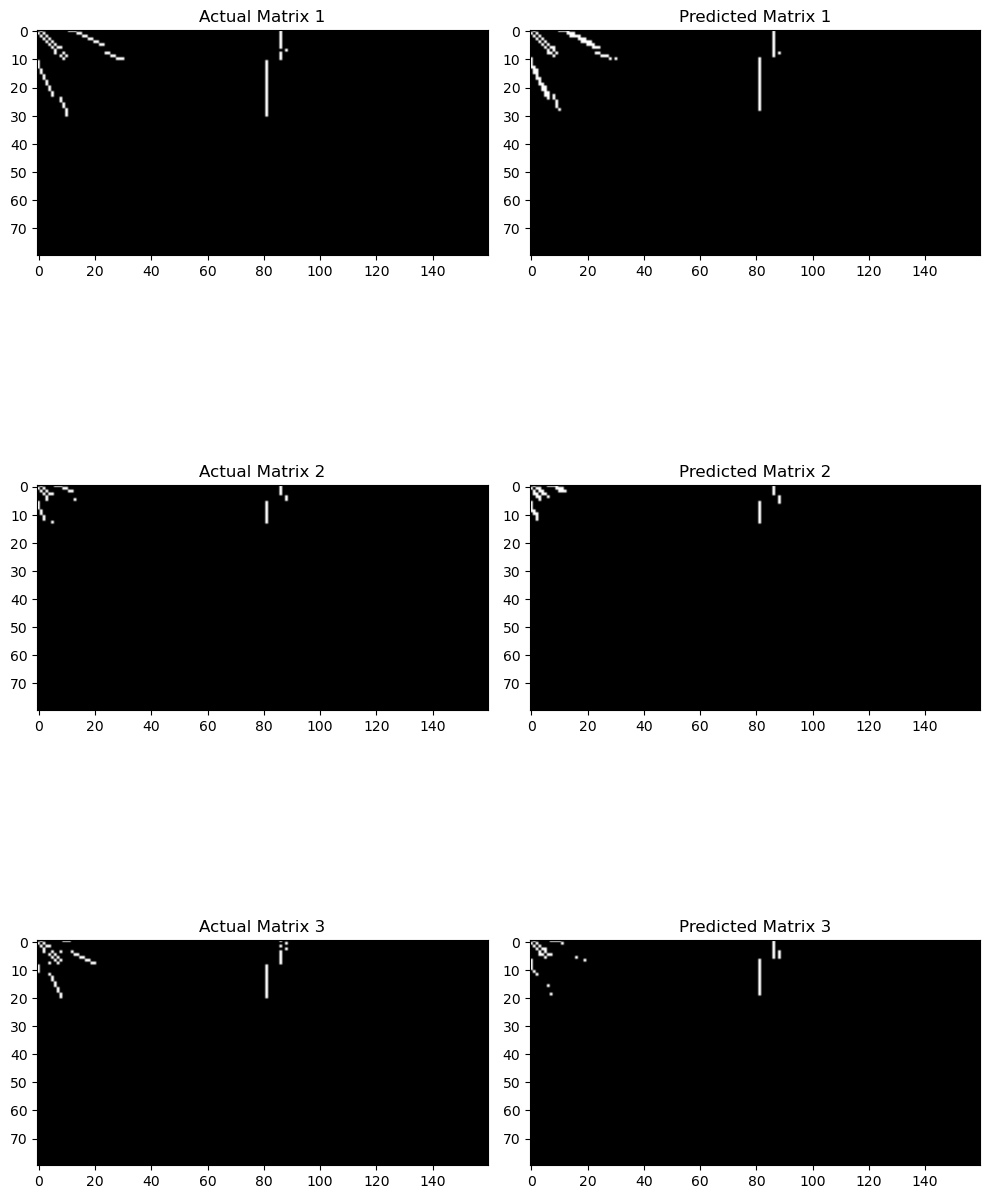

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


##############################################
# Evaluate the Model
##############################################

model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert predictions to binary matrices
threshold=0.3
y_pred_binary = (y_pred_tensor >= threshold).float()
y_test_binary = y_test_tensor

##############################################
# Calculate Metrics for the Matrix Prediction
##############################################

y_pred_flat = y_pred_binary.view(-1).numpy()
y_test_flat = y_test_binary.view(-1).numpy()

accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_test_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_test_flat, y_pred_flat, zero_division=0)

print("\nMetrics for Matrix Prediction:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")

# Log metrics to TensorBoard
writer.add_scalar('Metrics/Accuracy', accuracy)
writer.add_scalar('Metrics/Precision', precision)
writer.add_scalar('Metrics/Recall', recall)
writer.add_scalar('Metrics/F1_Score', f1)

# Close the TensorBoard writer
writer.close()

##############################################
# Final Visualization: Plot 3 Actual vs. Predicted Matrices
##############################################

def plot_final_predictions():
    """Plot the first three actual vs. predicted matrices."""
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    for i in range(3):
        axes[i, 0].imshow(y_test_binary[i].numpy(), cmap='gray')
        axes[i, 0].set_title(f'Actual Matrix {i + 1}')

        axes[i, 1].imshow(y_pred_binary[i].numpy(), cmap='gray')
        axes[i, 1].set_title(f'Predicted Matrix {i + 1}')

    plt.tight_layout()
    plt.show()

# Call the function to display the final predictions
plot_final_predictions()


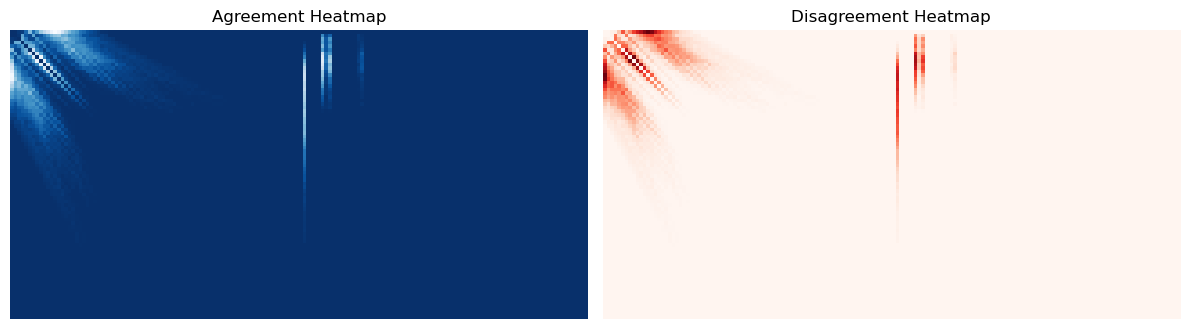

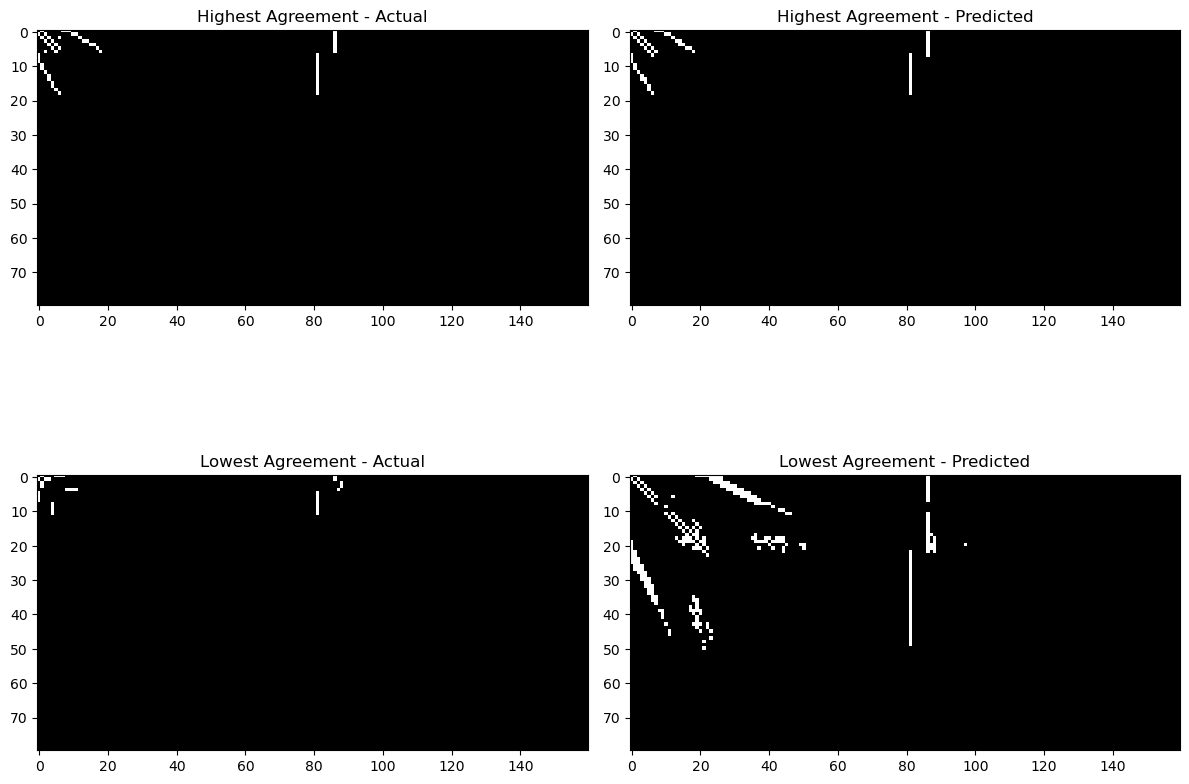

In [102]:
import numpy as np
import torch
import matplotlib.pyplot as plt

##############################################
# Compute Agreement and Disagreement
##############################################

# Element-wise agreement (1 if equal, 0 if not)
agreement_matrix = (y_pred_binary == y_test_binary).float().mean(dim=0).numpy()

# Element-wise disagreement (1 if not equal, 0 if equal)
disagreement_matrix = (y_pred_binary != y_test_binary).float().mean(dim=0).numpy()

##############################################
# Visualize Agreement and Disagreement
##############################################

def plot_agreement_disagreement(agreement, disagreement):
    """Plot heatmaps of agreement and disagreement."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot agreement heatmap
    axes[0].imshow(agreement, cmap='Blues', interpolation='nearest')
    axes[0].set_title('Agreement Heatmap')
    axes[0].axis('off')

    # Plot disagreement heatmap
    axes[1].imshow(disagreement, cmap='Reds', interpolation='nearest')
    axes[1].set_title('Disagreement Heatmap')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot agreement and disagreement heatmaps
plot_agreement_disagreement(agreement_matrix, disagreement_matrix)

##############################################
# Find the Areas with Highest and Lowest Agreement
##############################################

def highlight_agreement_disagreement(y_pred, y_test):
    """Plot examples with the highest and lowest agreement."""
    # Compute element-wise differences for each sample
    differences = (y_pred != y_test).float().sum(dim=(1, 2)).numpy()

    # Find the indices of the samples with the highest and lowest agreement
    highest_agreement_idx = np.argmin(differences)
    lowest_agreement_idx = np.argmax(differences)

    # Plot the highest and lowest agreement matrices
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Highest agreement
    axes[0, 0].imshow(y_test[highest_agreement_idx].numpy(), cmap='gray')
    axes[0, 0].set_title('Highest Agreement - Actual')
    axes[0, 1].imshow(y_pred[highest_agreement_idx].numpy(), cmap='gray')
    axes[0, 1].set_title('Highest Agreement - Predicted')

    # Lowest agreement
    axes[1, 0].imshow(y_test[lowest_agreement_idx].numpy(), cmap='gray')
    axes[1, 0].set_title('Lowest Agreement - Actual')
    axes[1, 1].imshow(y_pred[lowest_agreement_idx].numpy(), cmap='gray')
    axes[1, 1].set_title('Lowest Agreement - Predicted')

    plt.tight_layout()
    plt.show()

# Call the function to highlight agreement and disagreement
highlight_agreement_disagreement(y_pred_binary, y_test_binary)


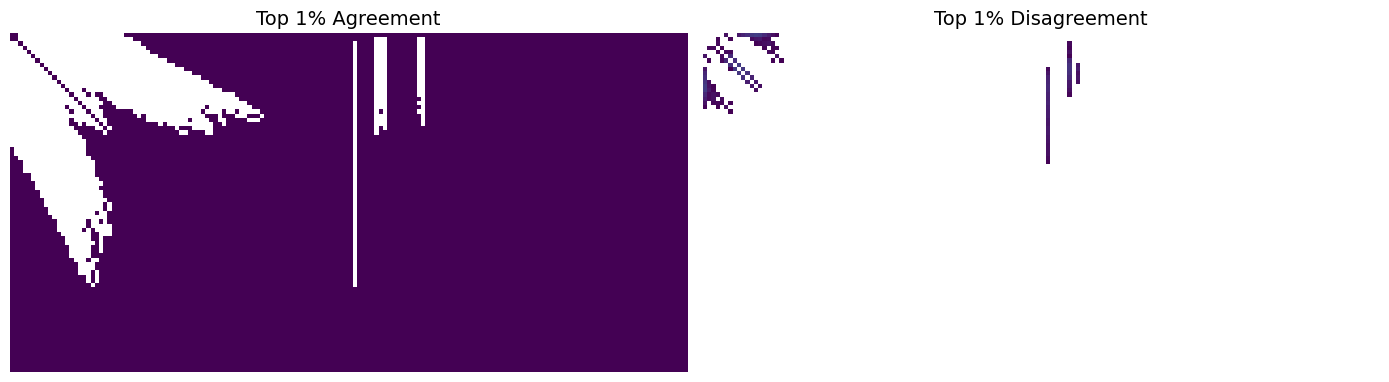

In [103]:
import numpy as np
import torch
import matplotlib.pyplot as plt

##############################################
# Compute Agreement and Disagreement
##############################################

# Element-wise agreement (1 if equal, 0 if not)
agreement_matrix = (y_pred_binary == y_test_binary).float().mean(dim=0).numpy()

# Element-wise disagreement (1 if not equal, 0 if equal)
disagreement_matrix = (y_pred_binary != y_test_binary).float().mean(dim=0).numpy()

##############################################
# Masking for Top Percentiles
##############################################

def apply_top_percentile_mask(matrix, percentile=1):
    """Create a masked matrix for the top percentile."""
    threshold = np.percentile(matrix, 100 - percentile)
    masked_top = np.where(matrix >= threshold, matrix, np.nan)
    return masked_top, threshold

# Apply masks for the top 1% percentile (default)
percentile = 1  # Default to 1%
agreement_top, agreement_threshold = apply_top_percentile_mask(agreement_matrix, percentile)
disagreement_top, disagreement_threshold = apply_top_percentile_mask(disagreement_matrix, percentile)

##############################################
# Visualize Top Agreement and Disagreement
##############################################

def plot_top_percentile_heatmaps(agreement_top, disagreement_top, agreement_threshold, disagreement_threshold, percentile):
    """Plot heatmaps for top percentile agreement/disagreement."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Top percentile agreement with a vibrant colormap, adjusted to top range
    axes[0].imshow(agreement_top, cmap='viridis', interpolation='nearest', 
                   vmin=agreement_threshold, vmax=1)
    axes[0].set_title(f'Top {percentile}% Agreement', fontsize=14)
    axes[0].axis('off')

    # Top percentile disagreement with a vibrant colormap, adjusted to top range
    axes[1].imshow(disagreement_top, cmap='viridis', interpolation='nearest', 
                   vmin=disagreement_threshold, vmax=1)
    axes[1].set_title(f'Top {percentile}% Disagreement', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Plot the heatmaps for top percentiles
plot_top_percentile_heatmaps(agreement_top, disagreement_top, agreement_threshold, disagreement_threshold, percentile)


In [104]:
df.keys()

Index(['NIST_molecule', 'CAS_NO', 'Name', 'molform', 'x', 'y', 'smiles',
       'Allenic', 'Vinylic', 'Arene', 'Alcohol', 'Ether', 'Amine', 'Imine',
       'Nitrile', 'Thiol', 'Sulfide', 'Disulfide', 'Aldehyde', 'Ketone',
       'CarboxylAcid', 'Ester', 'Thioester', 'Amide', 'AcidChloride',
       'Anhydride', 'Errors', 'Merged Adjacency Matrix', 'Matrix_Shape'],
      dtype='object')

In [106]:
from rdkit import Chem
from collections import Counter
import numpy as np
import pandas as pd

# Elements 1 to 20
atomic_numbers = list(range(1, 21))
periodic_table = Chem.GetPeriodicTable()
element_symbols = [periodic_table.GetElementSymbol(Z) for Z in atomic_numbers]

# ✅ Include implicit hydrogens by adding them explicitly
def get_stoichiometry_from_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # Add implicit H atoms explicitly
    atom_counts = Counter([atom.GetSymbol() for atom in mol.GetAtoms()])
    return {el: atom_counts.get(el, 0) for el in element_symbols}

# Run model predictions on test set
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).numpy()  # shape: (N, 80, 160)

# Map from 1-based atomic number to element symbol
element_map = {i + 1: periodic_table.GetElementSymbol(i + 1) for i in range(80)}

# Collect predicted counts (only atomic numbers 1–20)
pred_atom_counts_list = []
for pred_matrix in preds:
    summed = pred_matrix[:, 81:].sum(axis=0)  # columns 81–160 correspond to atomic numbers 1–80
    counts = {}
    for i, total in enumerate(summed):
        atomic_num = i + 1  # convert 0-indexed to atomic number
        if atomic_num in atomic_numbers:
            element = element_map.get(atomic_num)
            if total > 0:
                counts[element] = total
    pred_atom_counts_list.append(counts)

# Get SMILES from test split
_, X_test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# Compare predicted vs actual stoichiometry
stoichiometry_df = []
for i, idx in enumerate(X_test_idx):
    true_counts = get_stoichiometry_from_smiles(df.loc[idx, 'smiles'])
    pred_counts = pred_atom_counts_list[i]
    comparison = {'Index': idx}
    for el in element_symbols:
        comparison[f'{el}_actual'] = true_counts.get(el, 0)
        comparison[f'{el}_predicted'] = round(pred_counts.get(el, 0), 2)
    stoichiometry_df.append(comparison)

# Create DataFrame and remove zero-only columns (excluding Index)
things = ['Index'] + [f'{el}_actual' for el in element_symbols] + [f'{el}_predicted' for el in element_symbols]
stoichiometry_df = pd.DataFrame(stoichiometry_df)[things]

nonzero_cols = ['Index'] + [col for col in stoichiometry_df.columns if col != 'Index' and (stoichiometry_df[col] != 0).any()]
stoichiometry_df = stoichiometry_df[nonzero_cols]

display(stoichiometry_df)


,Index,H_actual,C_actual,N_actual,O_actual,S_actual,Cl_actual,H_predicted,C_predicted,N_predicted,O_predicted,F_predicted,S_predicted,Cl_predicted
0,3528,20,10,0,1,0,0,18.15,9.73,0.05,1.32,0.0,0.01,0.00
1,5359,8,4,0,2,0,0,7.88,3.71,0.19,2.35,0.0,0.30,0.29
2,1858,12,7,0,2,0,0,11.77,5.39,0.11,2.17,0.0,0.09,0.02
3,2523,12,14,2,2,0,0,12.10,16.73,0.53,0.92,0.0,0.10,0.97
4,4412,12,15,0,0,0,0,12.12,13.18,0.39,0.04,0.0,0.04,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,43,22,15,0,2,0,0,13.19,7.48,0.38,1.44,0.0,0.10,0.09
1130,5229,8,9,0,4,0,0,6.57,7.23,0.31,1.37,0.0,0.12,0.23
1131,3815,10,13,2,0,0,0,12.39,14.83,0.71,0.57,0.0,0.16,0.01
1132,1297,16,11,0,0,5,0,12.22,9.78,1.37,0.86,0.0,0.42,0.54


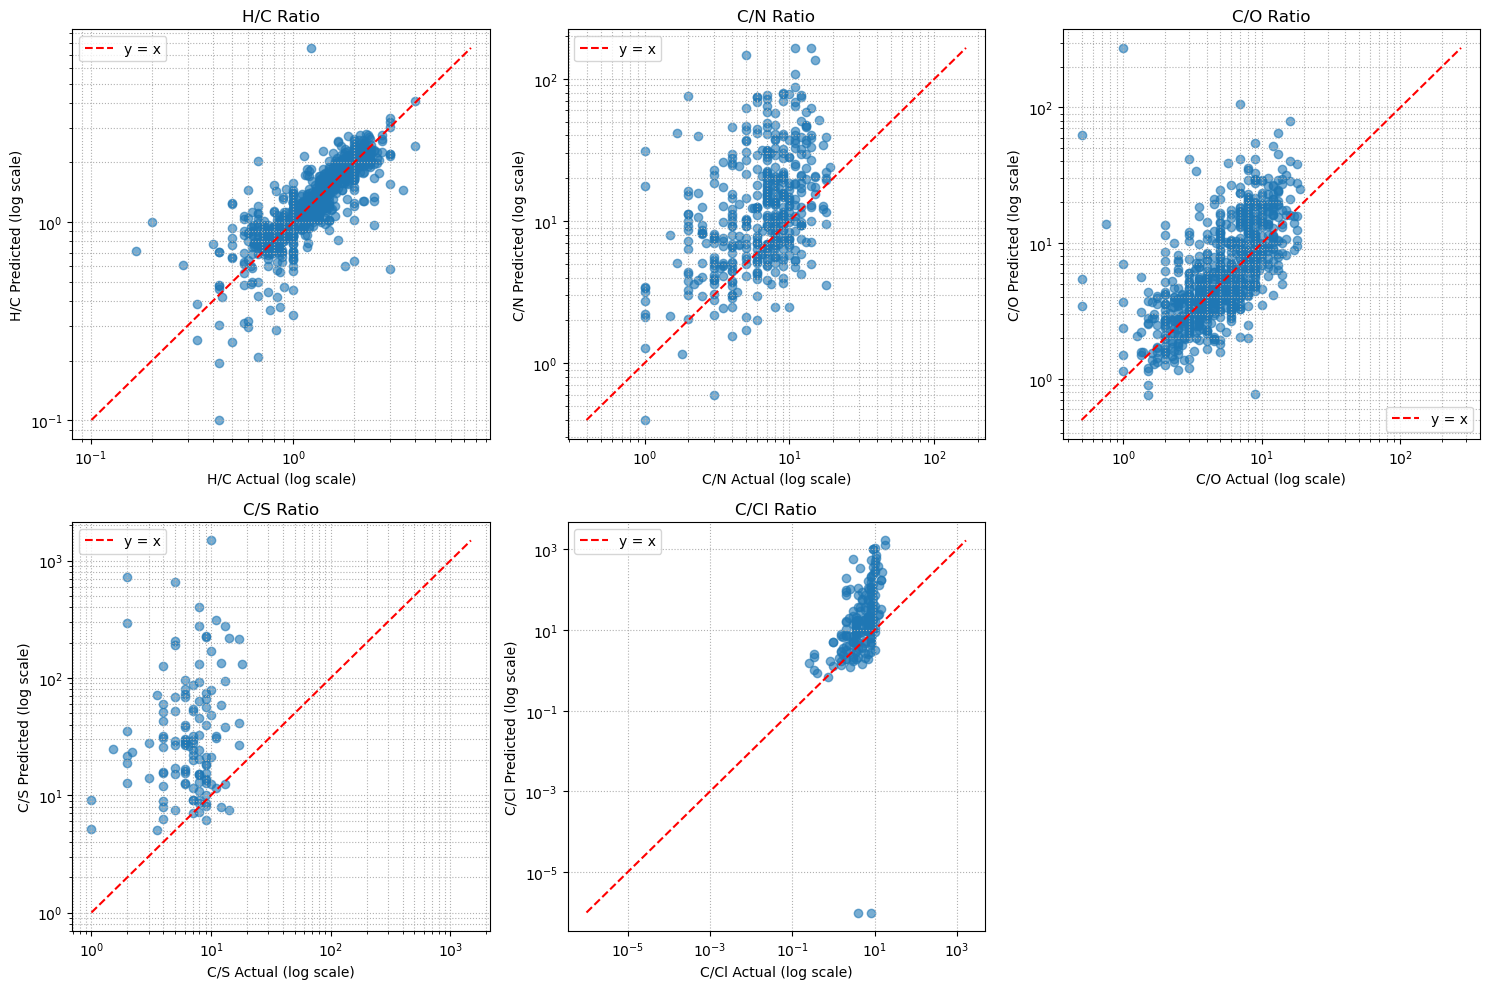

In [112]:
import matplotlib.pyplot as plt

# Define elemental ratios to plot: (numerator, denominator, label)
ratios = [
    ('H', 'C', 'H/C'),
    ('C', 'N', 'C/N'),
    ('C', 'O', 'C/O'),
    ('C', 'S', 'C/S'),
    ('C', 'Cl', 'C/Cl')
]

epsilon = 1e-6  # to avoid log(0)

# Compute and plot
plt.figure(figsize=(15, 10))

for i, (num, denom, label) in enumerate(ratios):
    # Extract numerator and denominator values
    num_actual = stoichiometry_df[f'{num}_actual'].replace(0, np.nan)
    denom_actual = stoichiometry_df[f'{denom}_actual'].replace(0, np.nan)
    num_pred = stoichiometry_df[f'{num}_predicted'].replace(0, np.nan)
    denom_pred = stoichiometry_df[f'{denom}_predicted'].replace(0, np.nan)

    # Calculate ratios
    actual_ratio = num_actual / denom_actual
    predicted_ratio = num_pred / denom_pred

    # Filter: only keep rows where actual numerator > 0 and actual_ratio > 1e-5
    valid = (num_actual > 0) & (actual_ratio > 1e-5)
    x = actual_ratio[valid].fillna(0) + epsilon
    y = predicted_ratio[valid].fillna(0) + epsilon

    # Plot
    plt.subplot(2, 3, i + 1)
    plt.scatter(x, y, alpha=0.6)
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(f'{label} Actual (log scale)')
    plt.ylabel(f'{label} Predicted (log scale)')
    plt.title(f'{label} Ratio')
    plt.grid(True, which='both', ls=':')
    plt.legend()

plt.tight_layout()
plt.show()


# Practice
The model at every 5 epochs is saved into a zip folder in  
`8615_parquet_files_release > 03_FTIR_to_structure`

1. Unzip this directory and move it to your working directory.
2. Load a different epoch (e.g., epoch 1000) and plot the ROC curve for that model state.
3. Also plot:
   - The highest agreement model
   - The lowest agreement model  
4. Compare both against the "best" model prediction.